# Step 1 - Weather Data Process - Camera to Weather Station Map

<b>Summary:</b><br>
Uses Synoptic Weather Data API to grab weather station metadata and map nearest stations to hpwren cameras.<br>
Synoptic is partner of SDG&E, helping store and serve their weather station data--accessible via API.

- Get weather station metadata via synoptic api
- Save raw weather station metadata file
- Read in processed camera metadata
- Filter out weather stations to ensure they have at least 1 years worth of data for time period
- Map up to x stations to each camera
- Save camera-to-stations mapping file

<b>Output:</b><br>
.<br>
├── data<br>
&emsp;&emsp;&emsp;├── processed<br>
&emsp;&emsp;&emsp;&nbsp;│&emsp;&emsp;&nbsp;├── camera_station_mappings.csv<br>
&emsp;&emsp;&emsp;└── raw<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;├── station_metadata.csv

<b>Instructions:</b><br>
- Create a copy of `config.json.example` and remove the `.example`
- Update the `synoptic_api_token` value

<b>Areas for Improvement:</b><br>
- Improve weather mapping; instead of choosing closest weather stations with at least 1 year of data, choose weather stations that have the most data within time range then closest

In [1]:
import json
import os
from ast import literal_eval
from datetime import datetime
from io import StringIO

import fastparquet
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import requests
import rtree
from dateutil.relativedelta import relativedelta
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from tqdm.notebook import tqdm, trange

## Parameters

In [2]:
# Base url and API token
with open("config.json") as config_file:
    cfg = json.load(config_file)

API_BASE_URL = "https://api.synopticdata.com/v2/"
API_TOKEN = cfg["synoptic_api_token"]

# should be SHORTNAME values from mesonet
WEATHER_NETWORKS = {139: "SDGE", 81: "HPWREN", 231: "SC-EDISON"}

# parameters for grabbing nearest stations to cameras
MILES = 35
CLOSEST_X = 3

# figlib start = 2016-06-04 (assume PST)
# figlib end = 2021-07-11 (assume PST)
# YYYYmmddHHMM (format needed for api)
START_DATETIME = "201606030000"
END_DATETIME = "202107120000"
# END_DATETIME = "202112311159"

## 1. Get all weather station metadata for the given networks

### Helper function to pull weather station metadata using synoptic API

In [3]:
def get_station_metadata(network: str) -> dict:
    """
    Return json dictionary of station metadata within given network(s).
    """
    endpoint = f"{API_BASE_URL}stations/metadata"
    params = {
        "token": API_TOKEN,
        "network": network,
        "status": "ACTIVE",
        "obtimezone": "UTC",
        "sensorvars": 1,
        "complete": 1,
    }
    r = requests.get(endpoint, params=params)
    if r.status_code not in range(200, 299):
        # TODO: add error handling
        print("Error!")
        return {}
    return r.json()

### Get station metadata for each network

In [4]:
# convert keys to strings and commma separate
networks = ",".join([str(i) for i in list(WEATHER_NETWORKS.keys())])
stations_df = pd.json_normalize(get_station_metadata(network=networks)["STATION"])

In [5]:
stations_df

,MNET_SHORTNAME,NWSFIREZONE,ELEV_DEM,TIMEZONE,SGID,SHORTNAME,ELEVATION,STID,WIMS_ID,GACC,...,SENSOR_VARIABLES.fuel_moisture.fuel_moisture_1.PERIOD_OF_RECORD.end,SENSOR_VARIABLES.precip_accum_one_hour.precip_accum_one_hour_1.position,SENSOR_VARIABLES.precip_accum_one_hour.precip_accum_one_hour_1.PERIOD_OF_RECORD.start,SENSOR_VARIABLES.precip_accum_one_hour.precip_accum_one_hour_1.PERIOD_OF_RECORD.end,SENSOR_VARIABLES.altimeter.altimeter_1.position,SENSOR_VARIABLES.altimeter.altimeter_1.PERIOD_OF_RECORD.start,SENSOR_VARIABLES.altimeter.altimeter_1.PERIOD_OF_RECORD.end,SENSOR_VARIABLES.precip_accum_ten_minute.precip_accum_ten_minute_1.position,SENSOR_VARIABLES.precip_accum_ten_minute.precip_accum_ten_minute_1.PERIOD_OF_RECORD.start,SENSOR_VARIABLES.precip_accum_ten_minute.precip_accum_ten_minute_1.PERIOD_OF_RECORD.end
0,HPWREN,SGX258,6223.8,America/Los_Angeles,SC11,HPWREN,6181,HP001,None,SOCC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HPWREN,SGX250,3700.8,America/Los_Angeles,SC08,HPWREN,3645,HP002,None,SOCC,...,2012-04-14T04:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HPWREN,SGX258,3070.9,America/Los_Angeles,SC08,HPWREN,3032,HP006,None,SOCC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HPWREN,SGX258,4878.6,America/Los_Angeles,SC11,HPWREN,3580,HP009,None,SOCC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HPWREN,SGX258,4235.6,America/Los_Angeles,SC11,HPWREN,4280,HP004,None,SOCC,...,NaN,NaN,2009-07-22T00:00:00Z,2013-08-14T16:52:00Z,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1770,SC-EDISON,LOX358,246.1,America/Los_Angeles,SC08,SC-EDISON,235,571SE,None,SOCC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1771,SC-EDISON,HNX596,None,America/Los_Angeles,SC03,SC-EDISON,3047,572SE,None,SOCC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1772,SC-EDISON,HNX596,None,America/Los_Angeles,SC03,SC-EDISON,3503,573SE,None,SOCC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1773,SC-EDISON,HNX595,None,America/Los_Angeles,SC03,SC-EDISON,4126,574SE,None,SOCC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Write data to csv output

In [6]:
stations_df.to_csv("../../data/raw/station_metadata.csv", index=False)

<hr>

## 2. Determine nearest weather stations for each camera "field of view"

Methodology:
- Determine camera direction
- Calculate distance from every camera to every station
- Determine if each station is in the correct direction of the camera
- For each camera, calculate a row number for each station by distance (only for cameras in direction)

- Filter dataset by the following:
    - Find stations within camera view distance: 35 miles
    - Find stations in front of camera direction: assume 180 degree fov
    - Limit to nearest x: 3

Areas for improvement:
- Adjust lens field of view from 180 degrees; in reality most camreas have 90 degree field of views with a fiew ~100 depending on camera model
- Camera distance is approximated upon analyzing a handful of different cameras and converting pixel to world coordinates; can be improved per camera if tilt angle known

### Read camera metadata

In [7]:
hpwren_cameras_metadata_df = pd.read_csv(
    "../../data/processed/camera_metadata_hpwren.csv"
)
print(hpwren_cameras_metadata_df.shape)

(103, 30)


### Convert camera coords to geospatial point

In [8]:
# set geometry.coordinates to list instead of string
hpwren_cameras_metadata_df["geometry.coordinates"] = hpwren_cameras_metadata_df[
    "geometry.coordinates"
].apply(lambda x: literal_eval(str(x)))

# split new list of coordinates into temp df with column for lat, long, altitude (row order retained)
temp_coords_df = pd.DataFrame(
    hpwren_cameras_metadata_df["geometry.coordinates"].tolist(),
    columns=["long", "lat", "elevation"],
)
temp_coords_df.head()

,long,lat,elevation
0,-117.1200,32.5500,10
1,-116.8081,33.1599,4055
2,-116.8081,33.1599,4055
3,-116.8081,33.1599,4055
4,-116.8081,33.1599,4055


In [9]:
# Generate spatial points for each camera lat, long
camera_geometry = [Point(xy) for xy in zip(temp_coords_df.long, temp_coords_df.lat)]

# Convert df to geopandas df and append geometry column
hpwren_cameras_metadata_gdf = GeoDataFrame(
    hpwren_cameras_metadata_df, crs="EPSG:4326", geometry=camera_geometry
)  # epsg code 4326 = wgs84

In [10]:
hpwren_cameras_metadata_gdf.head()[["geometry.coordinates", "geometry"]]

,geometry.coordinates,geometry
0,"[-117.12, 32.55, 10]",POINT (-117.12000 32.55000)
1,"[-116.8081, 33.1599, 4055]",POINT (-116.80810 33.15990)
2,"[-116.8081, 33.1599, 4055]",POINT (-116.80810 33.15990)
3,"[-116.8081, 33.1599, 4055]",POINT (-116.80810 33.15990)
4,"[-116.8081, 33.1599, 4055]",POINT (-116.80810 33.15990)


In [11]:
# Read US shapefile provied via: https://www.weather.gov/gis/USStates
states_gdf = geopandas.read_file("../../data/raw/s_22mr22/s_22mr22.shp")

<AxesSubplot:>

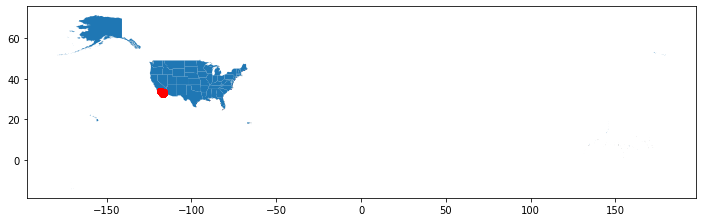

In [12]:
# Confirm only see points in CA approximately
fig, ax = plt.subplots(figsize=(12, 12))
states_gdf.plot(ax=ax)
hpwren_cameras_metadata_gdf.plot(ax=ax, color="red")

<AxesSubplot:>

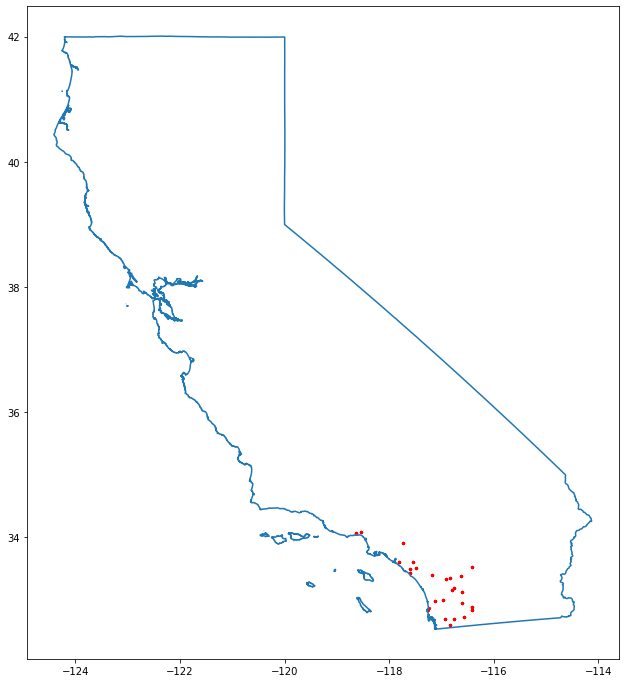

In [13]:
# Confirm only see points in southern CA approximately
fig, ax = plt.subplots(figsize=(12, 12))
states_gdf[states_gdf["STATE"] == "CA"].boundary.plot(ax=ax)
hpwren_cameras_metadata_gdf.plot(
    ax=ax, color="red", markersize=5
)  # keep in mind approx 4 cameras will share same location

### Create master dataset of each camera to each station with distance, is in direction, and row number by closeness

Currently assumes the following:
- lense field of view: 180 degrees
- unknown camera tilt angel, therefore, assume cameras can see 35 miles out

#### Read station metadata and convert to geodataframe

In [14]:
stations_df = pd.read_csv("../../data/raw/station_metadata.csv")
stations_df.shape

(1775, 73)

#### Filter out stations with late start time

In [15]:
# convert columns to datetime
stations_df["PERIOD_OF_RECORD.start"] = pd.to_datetime(
    stations_df["PERIOD_OF_RECORD.start"]
)
stations_df["PERIOD_OF_RECORD.end"] = pd.to_datetime(
    stations_df["PERIOD_OF_RECORD.end"]
)
stations_df[["PERIOD_OF_RECORD.start", "PERIOD_OF_RECORD.end"]].dtypes

PERIOD_OF_RECORD.start    datetime64[ns, UTC]
PERIOD_OF_RECORD.end      datetime64[ns, UTC]
dtype: object

In [16]:
# START_DATETIME = "201606030000"
# END_DATETIME = "202107120000"

# AT LEAST 1 YEAR OF DATA NEEDED FROM ENDS OF TIMEFRAME
end_datetime_dt = datetime.strptime(END_DATETIME, "%Y%m%d%H%M")
buffer_end_datetime_dt = end_datetime_dt - relativedelta(years=1)
start_datetime_dt = datetime.strptime(START_DATETIME, "%Y%m%d%H%M")
buffer_start_datetime_dt = start_datetime_dt + relativedelta(years=1)

stations_df = stations_df[
    (stations_df["PERIOD_OF_RECORD.start"].dt.date <= buffer_end_datetime_dt.date())
    & (stations_df["PERIOD_OF_RECORD.end"].dt.date >= buffer_start_datetime_dt.date())
].copy()
stations_df.shape

(1057, 73)

#### Convert to geopandas dataframe

In [17]:
station_geometry = [
    Point(xy) for xy in zip(stations_df.LONGITUDE, stations_df.LATITUDE)
]

# Convert df to geopandas df and append geometry column
stations_gdf = GeoDataFrame(
    stations_df, crs="EPSG:4326", geometry=station_geometry
)  # epsg code 4326 = wgs84
stations_stid_gdf = stations_gdf[["STID", "SHORTNAME", "geometry"]]
stations_stid_gdf

,STID,SHORTNAME,geometry
0,HP001,HPWREN,POINT (-116.42090 32.89220)
1,HP002,HPWREN,POINT (-116.76460 32.70150)
2,HP006,HPWREN,POINT (-116.98340 33.35040)
3,HP009,HPWREN,POINT (-116.61000 33.13000)
4,HP004,HPWREN,POINT (-116.76100 33.18800)
...,...,...,...
1053,SE881,SC-EDISON,POINT (-118.43331 34.41288)
1054,SE882,SC-EDISON,POINT (-118.06385 34.21727)
1055,SE883,SC-EDISON,POINT (-118.20136 34.18815)
1057,HP026,HPWREN,POINT (-118.54880 34.08640)


In [18]:
num_cameras = hpwren_cameras_metadata_gdf.shape[0]
num_stations = stations_stid_gdf.shape[0]
print(f"Num cameras: {num_cameras}")
print(f"Num stations: {num_stations}")
print(f"Num cross product: {num_cameras*num_stations}")

Num cameras: 103
Num stations: 1057
Num cross product: 108871


#### Create cartesian product of cameras x stations and calc distance, is in camera direction, and row num

In [19]:
# Create cartesian product of all camera x stations
cross_join_df = hpwren_cameras_metadata_gdf.merge(stations_stid_gdf, how="cross")
cross_join_df = cross_join_df.rename(
    columns={
        "geometry_x": "geometry",
        "STID": "stid",
        "SHORTNAME": "shortname",
        "geometry_y": "geometry_station",
    }
)
# df to gdf
cross_join_gdf = GeoDataFrame(
    cross_join_df, crs="EPSG:4326", geometry=cross_join_df["geometry"]
)

In [20]:
cross_join_gdf

,type,geometry.type,geometry.coordinates,properties.description.name,properties.description.id,properties.description.url,properties.latest-images,properties.description.sponsor,properties.description.tilt_current,properties.description.fov_center,...,properties.description.isp,properties.description.activated_at,properties.description.county,properties.description.az_current,properties.description.is_patrol_mode,direction,geometry,stid,shortname,geometry_station
0,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown direction,POINT (-117.12000 32.55000),HP001,HPWREN,POINT (-116.42090 32.89220)
1,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown direction,POINT (-117.12000 32.55000),HP002,HPWREN,POINT (-116.76460 32.70150)
2,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown direction,POINT (-117.12000 32.55000),HP006,HPWREN,POINT (-116.98340 33.35040)
3,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown direction,POINT (-117.12000 32.55000),HP009,HPWREN,POINT (-116.61000 33.13000)
4,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,unknown direction,POINT (-117.12000 32.55000),HP004,HPWREN,POINT (-116.76100 33.18800)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108866,Feature,Point,"[-117.481, 33.5191, 2300]",Upper Talega,hpwren30_west,http://hpwren.ucsd.edu/cameras/UpperTalega.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,west,POINT (-117.48100 33.51910),SE881,SC-EDISON,POINT (-118.43331 34.41288)
108867,Feature,Point,"[-117.481, 33.5191, 2300]",Upper Talega,hpwren30_west,http://hpwren.ucsd.edu/cameras/UpperTalega.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,west,POINT (-117.48100 33.51910),SE882,SC-EDISON,POINT (-118.06385 34.21727)
108868,Feature,Point,"[-117.481, 33.5191, 2300]",Upper Talega,hpwren30_west,http://hpwren.ucsd.edu/cameras/UpperTalega.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,west,POINT (-117.48100 33.51910),SE883,SC-EDISON,POINT (-118.20136 34.18815)
108869,Feature,Point,"[-117.481, 33.5191, 2300]",Upper Talega,hpwren30_west,http://hpwren.ucsd.edu/cameras/UpperTalega.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,west,POINT (-117.48100 33.51910),HP026,HPWREN,POINT (-118.54880 34.08640)


In [21]:
# Calculate distaince between all points
# convert wgs84 to nad83 for meter calculation
cross_join_gdf["geometry_camera_nad83"] = cross_join_gdf["geometry"].to_crs(3310)
cross_join_gdf["geometry_station_nad83"] = cross_join_gdf["geometry_station"].to_crs(
    3310
)


def calc_distance(row):
    distance_m = row["geometry_camera_nad83"].distance(row["geometry_station_nad83"])
    return distance_m


# distance in meters
cross_join_gdf["distance_m"] = cross_join_gdf.apply(
    lambda row: calc_distance(row), axis=1
)
# distance in miles: 1 mile = 1609.344 meters
cross_join_gdf["distance_mi"] = cross_join_gdf["distance_m"] / 1609.344

In [22]:
# Calculate if station is in camera direction
def is_in_direction(row):
    # assumes a 180 degree field of view (checks if above/below, left/right)
    direction = row["direction"].lower()
    if direction == "north":
        return row["geometry_station"].y >= row["geometry"].y
    elif direction == "east":
        return row["geometry_station"].x >= row["geometry"].x
    elif direction == "south":
        return row["geometry_station"].y <= row["geometry"].y
    elif direction == "west":
        return row["geometry_station"].x <= row["geometry"].x
    else:
        # unknown or something else
        pass


cross_join_gdf["is_in_direction"] = cross_join_gdf.apply(
    lambda row: is_in_direction(row), axis=1
)

In [23]:
# Calculate row number by closeness
# https://stackoverflow.com/questions/17775935/sql-like-window-functions-in-pandas-row-numbering-in-python-pandas-dataframe
cross_join_gdf = cross_join_gdf.sort_values(
    ["properties.description.id", "distance_mi"], ascending=[True, True]
)

# filter out the not in directions for proper cumcount
cross_join_filter_gdf = cross_join_gdf[
    cross_join_gdf["is_in_direction"] != False
].copy()

# manually filter out known stations with null percentages > 20%
stations_to_filter_out = ["HP003", "HP006", "HP015", "HP025"]
cross_join_filter_gdf = cross_join_filter_gdf[
    ~cross_join_filter_gdf["stid"].isin(stations_to_filter_out)
].copy()

cross_join_filter_gdf["rn"] = (
    cross_join_filter_gdf.groupby(["properties.description.id"]).cumcount() + 1
)

In [24]:
cross_join_filter_gdf

,type,geometry.type,geometry.coordinates,properties.description.name,properties.description.id,properties.description.url,properties.latest-images,properties.description.sponsor,properties.description.tilt_current,properties.description.fov_center,...,geometry,stid,shortname,geometry_station,geometry_camera_nad83,geometry_station_nad83,distance_m,distance_mi,is_in_direction,rn
170,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-117.12000 32.55000),BFDSD,SDGE,POINT (-117.09673 32.54197),POINT (270907.903 -602745.446),POINT (273123.340 -603567.295),2362.963219,1.468277,None,1
156,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-117.12000 32.55000),CVXSD,SDGE,POINT (-117.05801 32.60159),POINT (270907.903 -602745.446),POINT (276559.938 -596857.216),8161.908209,5.071575,None,2
661,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-117.12000 32.55000),DJZSD,SDGE,POINT (-117.11030 32.64190),POINT (270907.903 -602745.446),POINT (271509.966 -592547.121),10216.081526,6.347979,None,3
166,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-117.12000 32.55000),NATSD,SDGE,POINT (-117.09669 32.65434),POINT (270907.903 -602745.446),POINT (272746.158 -591131.221),11758.801848,7.306581,None,4
18,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-117.12000 32.55000),MIGSD,SDGE,POINT (-116.98091 32.68478),POINT (270907.903 -602745.446),POINT (283511.973 -587422.493),19840.752587,12.328472,None,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34395,Feature,Point,"[-118.63, 34.07, 2480]",L.A.Co.F.D Helibase 69 Bravo,hpwren9_west,http://hpwren.ucsd.edu/cameras/69bravo.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-118.63000 34.07000),SE406,SC-EDISON,POINT (-119.26899 38.22056),POINT (126450.553 -437488.475),POINT (63918.430 22945.879),464661.232198,288.727104,True,265
34392,Feature,Point,"[-118.63, 34.07, 2480]",L.A.Co.F.D Helibase 69 Bravo,hpwren9_west,http://hpwren.ucsd.edu/cameras/69bravo.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-118.63000 34.07000),SE403,SC-EDISON,POINT (-119.22612 38.25832),POINT (126450.553 -437488.475),POINT (67632.575 27173.066),468369.407666,291.031257,True,266
34394,Feature,Point,"[-118.63, 34.07, 2480]",L.A.Co.F.D Helibase 69 Bravo,hpwren9_west,http://hpwren.ucsd.edu/cameras/69bravo.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-118.63000 34.07000),SE405,SC-EDISON,POINT (-119.21323 38.30325),POINT (126450.553 -437488.475),POINT (68717.613 32176.768),473200.309874,294.033041,True,267
34391,Feature,Point,"[-118.63, 34.07, 2480]",L.A.Co.F.D Helibase 69 Bravo,hpwren9_west,http://hpwren.ucsd.edu/cameras/69bravo.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-118.63000 34.07000),SE402,SC-EDISON,POINT (-119.34465 38.35050),POINT (126450.553 -437488.475),POINT (57203.097 37341.815),479853.118202,298.166904,True,268


#### Apply filter logic to master dataset to find matches within criterium

In [25]:
cross_join_matches_gdf = cross_join_filter_gdf[
    (cross_join_filter_gdf["distance_mi"] <= MILES)
    & (cross_join_filter_gdf["is_in_direction"] != False)
    & (cross_join_filter_gdf["rn"] <= CLOSEST_X)
].copy()
cross_join_matches_gdf

,type,geometry.type,geometry.coordinates,properties.description.name,properties.description.id,properties.description.url,properties.latest-images,properties.description.sponsor,properties.description.tilt_current,properties.description.fov_center,...,geometry,stid,shortname,geometry_station,geometry_camera_nad83,geometry_station_nad83,distance_m,distance_mi,is_in_direction,rn
170,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-117.12000 32.55000),BFDSD,SDGE,POINT (-117.09673 32.54197),POINT (270907.903 -602745.446),POINT (273123.340 -603567.295),2362.963219,1.468277,None,1
156,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-117.12000 32.55000),CVXSD,SDGE,POINT (-117.05801 32.60159),POINT (270907.903 -602745.446),POINT (276559.938 -596857.216),8161.908209,5.071575,None,2
661,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-117.12000 32.55000),DJZSD,SDGE,POINT (-117.11030 32.64190),POINT (270907.903 -602745.446),POINT (271509.966 -592547.121),10216.081526,6.347979,None,3
36050,Feature,Point,"[-116.58, 32.73, 4800]",Los Pinos,hpwren11_east,http://hpwren.ucsd.edu/cameras/LosPinos.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-116.58000 32.73000),CTMSD,SDGE,POINT (-116.54971 32.78287),POINT (320964.028 -581139.684),POINT (323592.432 -575185.363),6508.643922,4.044284,True,1
35969,Feature,Point,"[-116.58, 32.73, 4800]",Los Pinos,hpwren11_east,http://hpwren.ucsd.edu/cameras/LosPinos.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-116.58000 32.73000),MORSD,SDGE,POINT (-116.51244 32.68833),POINT (320964.028 -581139.684),POINT (327471.351 -585520.106),7844.319639,4.874234,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33416,Feature,Point,"[-118.63, 34.07, 2480]",L.A.Co.F.D Helibase 69 Bravo,hpwren9_south,http://hpwren.ucsd.edu/cameras/69bravo.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-118.63000 34.07000),SE473,SC-EDISON,POINT (-118.63911 34.05592),POINT (126450.553 -437488.475),POINT (125632.179 -439062.320),1773.900053,1.102250,True,2
33677,Feature,Point,"[-118.63, 34.07, 2480]",L.A.Co.F.D Helibase 69 Bravo,hpwren9_south,http://hpwren.ucsd.edu/cameras/69bravo.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-118.63000 34.07000),SE734,SC-EDISON,POINT (-118.67310 34.04092),POINT (126450.553 -437488.475),POINT (122517.846 -440770.560),5122.329166,3.182868,True,3
34473,Feature,Point,"[-118.63, 34.07, 2480]",L.A.Co.F.D Helibase 69 Bravo,hpwren9_west,http://hpwren.ucsd.edu/cameras/69bravo.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-118.63000 34.07000),SE473,SC-EDISON,POINT (-118.63911 34.05592),POINT (126450.553 -437488.475),POINT (125632.179 -439062.320),1773.900053,1.102250,True,1
34001,Feature,Point,"[-118.63, 34.07, 2480]",L.A.Co.F.D Helibase 69 Bravo,hpwren9_west,http://hpwren.ucsd.edu/cameras/69bravo.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,POINT (-118.63000 34.07000),SE003,SC-EDISON,POINT (-118.65901 34.07684),POINT (126450.553 -437488.475),POINT (123762.388 -436768.063),2783.024239,1.729291,True,2


### Join back to original camera dataset to account for none matches + Write to CSV

In [26]:
hpwren_cameras_metadata_gdf.shape

(103, 31)

In [27]:
cams_to_stations_df = hpwren_cameras_metadata_gdf.merge(
    cross_join_matches_gdf[
        [
            "properties.description.id",
            "stid",
            "shortname",
            "distance_m",
            "distance_mi",
            "is_in_direction",
            "rn",
        ]
    ],
    on="properties.description.id",
    how="left",
)

cams_to_stations_df[
    [
        "properties.description.id",
        "stid",
        "shortname",
        "distance_m",
        "distance_mi",
        "is_in_direction",
        "rn",
    ]
].to_csv("../../data/processed/camera_station_mappings.csv", index=False)
cams_to_stations_df

,type,geometry.type,geometry.coordinates,properties.description.name,properties.description.id,properties.description.url,properties.latest-images,properties.description.sponsor,properties.description.tilt_current,properties.description.fov_center,...,properties.description.az_current,properties.description.is_patrol_mode,direction,geometry,stid,shortname,distance_m,distance_mi,is_in_direction,rn
0,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,unknown direction,POINT (-117.12000 32.55000),BFDSD,SDGE,2362.963219,1.468277,None,1
1,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,unknown direction,POINT (-117.12000 32.55000),CVXSD,SDGE,8161.908209,5.071575,None,2
2,Feature,Point,"[-117.12, 32.55, 10]",NaN,hpwren0_unknown direction,http://hpwren.ucsd.edu/cameras/TJE.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,unknown direction,POINT (-117.12000 32.55000),DJZSD,SDGE,10216.081526,6.347979,None,3
3,Feature,Point,"[-116.8081, 33.1599, 4055]",Big Black Mountain,hpwren1_north,http://hpwren.ucsd.edu/cameras/BBlackMtn.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,north,POINT (-116.80810 33.15990),HP016,HPWREN,0.000000,0.000000,True,1
4,Feature,Point,"[-116.8081, 33.1599, 4055]",Big Black Mountain,hpwren1_north,http://hpwren.ucsd.edu/cameras/BBlackMtn.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,north,POINT (-116.80810 33.15990),MGDSD,SDGE,4637.139293,2.881385,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,Feature,Point,"[-117.481, 33.5191, 2300]",Upper Talega,hpwren30_south,http://hpwren.ucsd.edu/cameras/UpperTalega.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,south,POINT (-117.48100 33.51910),TLGSD,SDGE,4521.722898,2.809668,True,2
305,Feature,Point,"[-117.481, 33.5191, 2300]",Upper Talega,hpwren30_south,http://hpwren.ucsd.edu/cameras/UpperTalega.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,south,POINT (-117.48100 33.51910),CRISD,SDGE,8167.055431,5.074773,True,3
306,Feature,Point,"[-117.481, 33.5191, 2300]",Upper Talega,hpwren30_west,http://hpwren.ucsd.edu/cameras/UpperTalega.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,west,POINT (-117.48100 33.51910),HP024,HPWREN,0.000000,0.000000,True,1
307,Feature,Point,"[-117.481, 33.5191, 2300]",Upper Talega,hpwren30_west,http://hpwren.ucsd.edu/cameras/UpperTalega.html,[[{'image': 'http://hpwren.ucsd.edu/cameras/L/...,NaN,NaN,NaN,...,NaN,NaN,west,POINT (-117.48100 33.51910),TLGSD,SDGE,4521.722898,2.809668,True,2


#### Null weather station mappings

In [28]:
cams_to_stations_df[cams_to_stations_df["stid"].isna()]

,type,geometry.type,geometry.coordinates,properties.description.name,properties.description.id,properties.description.url,properties.latest-images,properties.description.sponsor,properties.description.tilt_current,properties.description.fov_center,...,properties.description.az_current,properties.description.is_patrol_mode,direction,geometry,stid,shortname,distance_m,distance_mi,is_in_direction,rn


#### Denormalize for easier mapping view

In [29]:
cams_to_stations_map_df = pd.DataFrame(
    cams_to_stations_df[["properties.description.id", "stid"]]
    .groupby(["properties.description.id"])["stid"]
    .apply(list)
)
cams_to_stations_map_df

,stid
properties.description.id,
hpwren0_unknown direction,"[BFDSD, CVXSD, DJZSD]"
hpwren11_east,"[CTMSD, MORSD, BMSSD]"
hpwren11_north,"[CTMSD, BMSSD, JVRSD]"
hpwren11_south,"[MORSD, RPOSD, NPTSD]"
hpwren11_west,"[JVRSD, RPOSD, NPTSD]"
...,...
hpwren8_west,"[PAMSD, CLNSD, HP014]"
hpwren9_east,"[SE299, SE007, SE030]"
hpwren9_north,"[SE003, SE867, SE007]"
